# QAOA Max Cut

Wayne Nixalo – 2018/6/7-8

---

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
import networkx as nx

from grove.pyqaoa.qaoa import QAOA
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.gates import H
from pyquil.api import QVMConnection
import pyquil.quil as pq

from functools import reduce
from collections import Counter

In [4]:
display_options = {'node_color' :"#6CAFB7",
                   'node_size'  :250,
                   'with_labels': True}

## 1. 'Classical' Solver

Low-level worker functions

In [5]:
def internal_edge(edge, graph):
    """Checks if edge is internal to graph."""
    return edge in graph.edges

def single_endpoint(edge, graph):
    """Checks that an edge has a single endpoint in graph."""
    return list(graph.edges()).count(edge) == 1

def get_edges_from_nodes(nodes, graph):
    """Retreives all edges connected to nodes in graph."""
    edges = []
    for node in nodes:
        for edge in graph.edges:
            if node in edge:
                edges.append(edge)
    return edges

def edges_between(edges_A, edges_B):
    """Gets the number of edges shared by edges_A and edges_B."""
    count = 0
    for edge in edges_A:
        count += set(edge) in map(set, edges_B)
    return count

def get_unique_permutations(nodes, split_idx):
    """Returns all unique combinations of nodes split at split_idx."""
    nodes_A,nodes_B = [],[]
    nodes = list(nodes)
    # get all unique combos up to the split
    for perm in itertools.permutations(nodes, split_idx+1):
        if set(perm) not in nodes_A: nodes_A.append(set(perm))
    # cast the sets back to lists
    nodes_A = list(map(list, nodes_A))
    # get all unique combos after the split
    for perm in nodes_A:
        add_nodes = nodes.copy()
        for node in perm: 
            add_nodes.remove(node)
        nodes_B.append(add_nodes)
    # return permutations of split pairs
    return nodes_A, nodes_B

Validation

In [6]:
def valid_cut(nodes_AB, edges_AB, graph):
    """Determines if a cut is valid."""
    
    nodes_A, nodes_B = nodes_AB
    edges_A, edges_B = edges_AB
    valid_cut = True
    
    # get edges of cut
    edges_A = get_edges_from_nodes(nodes_A, graph)
    edges_B = get_edges_from_nodes(nodes_B, graph)

    # check no internal edges
    A_internal = graph.copy()
    B_internal = graph.copy()
    A_internal.remove_nodes_from(nodes_B)
    B_internal.remove_nodes_from(nodes_A)
    
    for graph in (A_internal, B_internal): 
        if len(graph.edges) > 0: 
            valid_cut = False
            break

    # check all single endpoints – (check first no internals)
    if valid_cut: valid_cut = set(edges_B)==set(edges_A)
        
    return valid_cut

Finder

In [7]:
def find_max_cut(graph):
    """Finds the Max Cut of a Bipartite Graph."""
    max_crossed = 0

    # get cut splits
    n_nodes = len(graph.nodes)
    split_idxs = list(range(0, int(n_nodes//2)))

    # iterate through all unique cut sizes
    for split_idx in split_idxs:
        permutations = get_unique_permutations(graph.nodes, split_idx)

        # iterate through all unique node permutations (Select Cut)
        for nodes_A, nodes_B in list(zip(*permutations)):

            # get edges of cut
            edges_A = get_edges_from_nodes(nodes_A, graph)
            edges_B = get_edges_from_nodes(nodes_B, graph)

            # check no internal edges and check all single endpoints
            if not valid_cut((nodes_A, nodes_B), (edges_A, edges_B), graph):
                continue

            # count crossed edges
            count = edges_between(edges_A, edges_B)
            if count > max_crossed:
                max_crossed = count
                max_cut = [nodes_A, nodes_B]
                
    # check max cut exists
    if max_crossed == 0:
        max_cut = [None, None]
    
    return max_crossed, max_cut

## 2. Example run:

8 [['w', 'x'], ['u', 'v', 'y', 'z']]
CPU times: user 36.9 ms, sys: 3.09 ms, total: 40 ms
Wall time: 38.7 ms


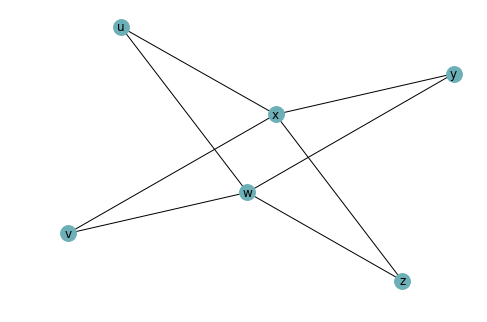

In [12]:
%%time

# create graph
g = nx.Graph()
g.add_nodes_from("uvwxyz")
edges = [('u','x'),('u','w'),('v','w'),('v','x'),
         ('y','w'),('y','x'),('z','w'),('z','x')]
g.add_edges_from(edges)

# find max cut
max_crossed, max_cut = find_max_cut(g)

# display
print(f"{max_crossed} {max_cut}")
nx.draw(g, **display_options)

## 3. 'Quantum' Solver

In [13]:
q_sim = QVMConnection()

`u`, `v`, `node` must all be integers to serve as indices. A dictionary will be needed to map non-integer nodes  & edge names.

In [14]:
graph = nx.Graph()
graph.add_nodes_from([0,1,2,3,4,5])
edges = [(0,3),(0,2),(1,2),(1,3),
         (4,2),(4,3),(5,2),(5,3)]
graph.add_edges_from(edges)

In [15]:
graph.nodes, graph.edges

(NodeView((0, 1, 2, 3, 4, 5)),
 EdgeView([(0, 3), (0, 2), (1, 2), (1, 3), (2, 4), (2, 5), (3, 4), (3, 5)]))

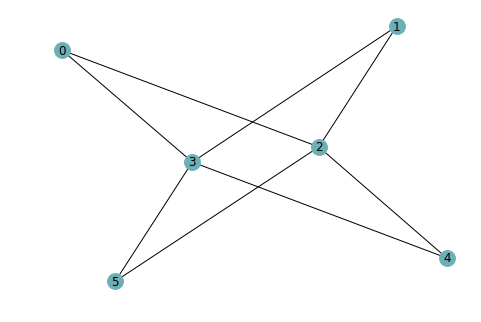

In [27]:
nx.draw(graph, **display_options)

In [28]:
cost_operators, driver_operators = [],[]

for u,v in graph.edges():
    cost_operators.append(PauliTerm("Z", u, 0.5) *
                          PauliTerm("Z", v)      +
                          PauliTerm("I", 0, -0.5))
for node in graph.nodes():
    driver_operators.append(PauliSum([PauliTerm("X", node, 1.0)]))

In [29]:
program = pq.Program()
for node in graph.nodes():
    program.inst(H(node))

In [30]:
max_cut_instance = QAOA(qvm=q_sim, n_qubits=len(graph.nodes()), steps=1, 
            ref_hamiltonian=driver_operators, cost_ham=cost_operators,
            driver_ref=program, store_basis=True)

In [31]:
betas, gammas = max_cut_instance.get_angles()

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -5.574359
         Iterations: 20
         Function evaluations: 35


In [32]:
# get paramaterized program
param_program = max_cut_instance.get_parameterized_program()
sampling_program = param_program(np.hstack((betas, gammas)))

# use run_and_measure QVM API to prepare circuit & measure qubits
bitstring_samples = q_sim.run_and_measure(quil_program=sampling_program,
                        qubits=range(len(graph.nodes())), trials=1000)
bitstring_tuples  = map(tuple, bitstring_samples)

# aggregate statistics
freq = Counter(bitstring_tuples)
max_freq_string = max(freq, key=lambda x: freq[x])

In [33]:
def get_max_from_bit_freqs(freq):
    for bit_string_freq in freq.items():
        if bit_string_freq[1] == max(freq.values()):
            max_cut = bit_string_freq
    return max_cut

QAOA algorithm says indices [0,1,4,5] and [2,3]:

In [34]:
max_cut = get_max_from_bit_freqs(freq);
max_cut

((1, 1, 0, 0, 1, 1), 162)

Brute force algorith agrees:

In [35]:
find_max_cut(graph)

(8, [[2, 3], [0, 1, 4, 5]])

### 3.1 Refactored:

In [36]:
def QAOA_max_cut(graph):
    q_sim = QVMConnection()

    cost_operators, driver_operators = [],[]

    for u,v in graph.edges():
        cost_operators.append(PauliTerm("Z", u, 0.5) *
                              PauliTerm("Z", v)      +
                              PauliTerm("I", 0, -0.5))
    for node in graph.nodes():
        driver_operators.append(PauliSum([PauliTerm("X", node, 1.0)]))

    program = pq.Program()
    
    for node in graph.nodes():
        program.inst(H(node))

    max_cut_instance = QAOA(qvm=q_sim, n_qubits=len(graph.nodes()), steps=1, 
                ref_hamiltonian=driver_operators, cost_ham=cost_operators,
                driver_ref=program, store_basis=True)

    betas, gammas = max_cut_instance.get_angles()

    # get paramaterized program
    param_program = max_cut_instance.get_parameterized_program()
    sampling_program = param_program(np.hstack((betas, gammas)))

    # use run_and_measure QVM API to prepare circuit & measure qubits
    bitstring_samples = q_sim.run_and_measure(quil_program=sampling_program,
                            qubits=range(len(graph.nodes())), trials=1000)
    bitstring_tuples  = map(tuple, bitstring_samples)

    # aggregate statistics
    freqs = Counter(bitstring_tuples)
    
    return freqs, {'betas':betas, 'gammas':gammas,
                   'inst':max_cut_instance, 'program':program,
                   'costop':cost_operators, 'drivop':driver_operators}

## 4. Random Graph:

In [52]:
def gen_random_graph(n=6, min_p=0.5):
    """Build a random graph with at least `min_p` percent 
       of its edges removed. Manual check for no isolated 
       nodes required.
    """
    graph = nx.complete_graph(n)
    
    # choose random number of edges to remove
    n_remove = int(max(min_p, np.random.random()) * len(graph.edges))
    # built list of edges to remove
    remove_idxs = np.random.choice(range(len(graph.edges)), size=n_remove, replace=False)
    edges_list = list(graph.edges)
    removes = [edges_list[idx] for idx in remove_idxs]
    # remove edges
    graph.remove_edges_from(removes)
    
    return graph

In [124]:
n = 12
graph = gen_random_graph(n=n)
# check no isolated nodes. see: https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html#networkx.algorithms.components.connected_components
[len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)][0] == n

True

In [125]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

In [126]:
graph.edges

EdgeView([(0, 8), (1, 2), (1, 4), (3, 8), (4, 7), (4, 9), (5, 8), (6, 8), (6, 10), (9, 10), (9, 11)])

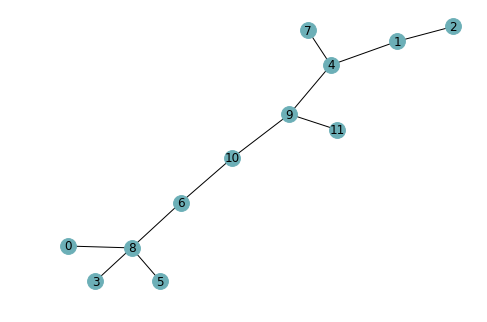

In [127]:
nx.draw(graph, **display_options)

In [128]:
%%time
freqs, var_dict = QAOA_max_cut(graph)
max_cut = get_max_from_bit_freqs(freqs)
print(max_cut)

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -8.090991
         Iterations: 22
         Function evaluations: 44
((0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1), 15)
CPU times: user 583 ms, sys: 24.1 ms, total: 607 ms
Wall time: 8.61 s


In [129]:
%%time
# brute force check
find_max_cut(graph)

CPU times: user 11.1 s, sys: 37.2 ms, total: 11.1 s
Wall time: 11.2 s


(11, [[2, 4, 8, 10, 11], [0, 1, 3, 5, 6, 7, 9]])

**NOTE** this time things worked, but this is rare. I think this was one of the few random graphs that were bipartite and thus solvable.

### 4.1 Plotting Bit Strings

In [130]:
def qubit_plot(inst, probs, n_qubits):
    probs = probs.real
    states = inst.states
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("state",fontsize=20)
    ax.set_ylabel("Probability",fontsize=20)
    ax.set_xlim([0, 2**n_qubits])
    rec = ax.bar(range(2**n_qubits), probs[:,0],)
    num_states = [0, 
                  int("".join(str(x) for x in [0,1] * (n_qubits//2)), 2),
                  int("".join(str(x) for x in [1,0] * (n_qubits//2)), 2),
                  2**n_qubits - 1]
    ax.set_xticks(num_states)
    ax.set_xticklabels(map(lambda x: inst.states[x], num_states), rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

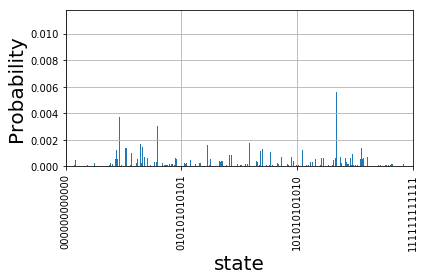

In [131]:
n_qubits = len(graph.nodes())
betas  = var_dict['betas']
gammas = var_dict['gammas']
t = np.hstack((betas,gammas))
max_cut_instance = var_dict['inst']
probs = max_cut_instance.probabilities(t)
qubit_plot(max_cut_instance, probs, n_qubits)

## 5 Random Graph 2

A more typical example of running QAOA & Brute-Force Max Cut on a random graph:

In [135]:
n = 12
graph = gen_random_graph(n=n)
# check no isolated nodes. see: https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html#networkx.algorithms.components.connected_components
[len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)][0] == n

True

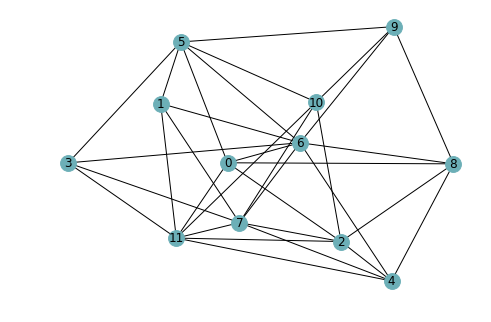

In [136]:
nx.draw(graph, **display_options)

In [137]:
%%time
freqs, var_dict = QAOA_max_cut(graph)
max_cut = get_max_from_bit_freqs(freqs)
print(max_cut)

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -16.682567
         Iterations: 19
         Function evaluations: 37
((1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1), 8)
CPU times: user 1.34 s, sys: 38.1 ms, total: 1.38 s
Wall time: 12.3 s


In [138]:
%%time
# brute force check
find_max_cut(graph)

CPU times: user 11.9 s, sys: 46.5 ms, total: 11.9 s
Wall time: 12 s


(0, [None, None])

Hmmm. Maybe I wrote the BF algo wrong. Maybe there's no solution. I'm thinking adding a constraint for a random *bipartite* graph may help.

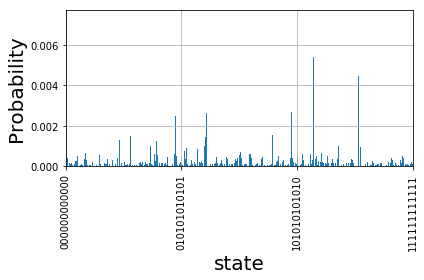

In [139]:
n_qubits = len(graph.nodes())
betas  = var_dict['betas']
gammas = var_dict['gammas']
t = np.hstack((betas,gammas))
max_cut_instance = var_dict['inst']
probs = max_cut_instance.probabilities(t)
qubit_plot(max_cut_instance, probs, n_qubits)

## Comments

My guess is the random graphs are the issue. I'm new to this problem, but there does not look like there's any intuitive way to do a max cut on many of the random graphs I've been generating.

I tried cutting larger fractions of their edges, but that too often resulted in unconnected graphs. My implementation of QAOA (which, to be fair, consists mostly of me calling Grove and using the pyQuil Forest API) *does* find the correct max cut for the simple 6-node graph –– and that graph is bipartite: I got it from a Tim Roughgarden lecture.

If there were more time I'd write a routine to generate guaranteed bipartite graphs, but the problem statement did say:

> solve a simple max-cut problem on a small random graph of roughly a dozen nodes.

So I think the more important thing was seeing how someone would handle the assignment.

*However*, when there was a solution found (it took a couple dozen tries of creating a random graph) both the brute-force checker and the QAOA agreed. That was very satisfying.

In any case, seeing the QAOA algorithm solve the first graph, by I guess (simulated) electron spin as bits, was very creepy in a cool way.